<a href="https://colab.research.google.com/github/bksat90/LLM/blob/main/LLM_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers
!pip install datasets

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow as tf
import seaborn as sns
import os


from sklearn.metrics import confusion_matrix, roc_curve
from datasets import load_dataset
from transformers import (BertTokenizerFast,TFBertTokenizer,BertTokenizer,RobertaTokenizerFast,
                          DataCollatorWithPadding,TFRobertaForSequenceClassification,TFBertForSequenceClassification,
                          TFBertModel,create_optimizer)

In [3]:
BATCH_SIZE = 16
EPOCHS = 2

In [4]:
# load data
dset = load_dataset("imdb")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [5]:
print(dset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})


In [6]:
dset.set_format(type="pandas")
df = dset["train"][:]
df.head()

,text,label
0,I rented I AM CURIOUS-YELLOW from my video sto...,0
1,"""I Am Curious: Yellow"" is a risible and preten...",0
2,If only to avoid making this type of film in t...,0
3,This film was probably inspired by Godard's Ma...,0
4,"Oh, brother...after hearing about this ridicul...",0


In [7]:
categories = df.label.value_counts()

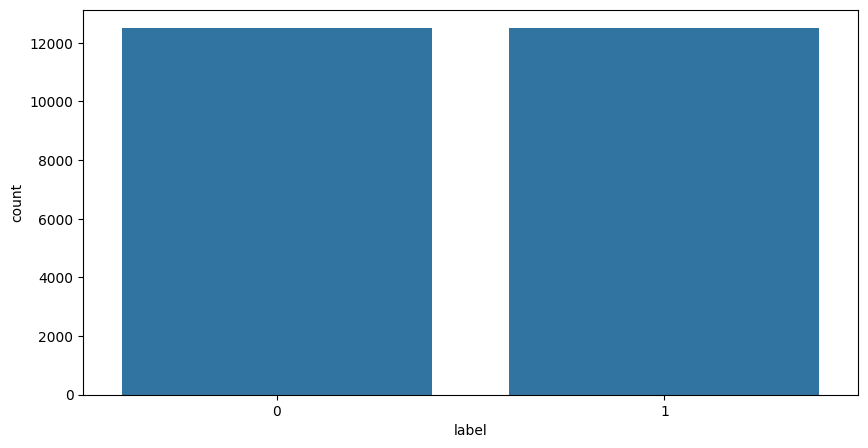

In [8]:
plt.figure(figsize=(10,5))
sns.barplot(categories)
plt.show()

In [9]:
# loading model
model_name="bert-base-uncased"
tokenizer = BertTokenizerFast.from_pretrained(model_name)

In [10]:
data = load_dataset("imdb")

In [11]:
def preprocessing(examples):
  return tokenizer(examples["text"],padding=True,truncation=True,)

In [ ]:
tokenized_dset = data.map(preprocessing, batched=True)
tokenized_dset

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

In [ ]:
# Train dataset
train_dataset = tokenized_dset["train"].to_tf_dataset(
    columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'],
    shuffle=True,
    batch_size=BATCH_SIZE,
)

In [ ]:
# validation dataset
val_dataset = tokenized_dset["test"].to_tf_dataset(
    columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'],
    shuffle=True,
    batch_size=BATCH_SIZE,
)

In [ ]:
def change_datatype(data):
  return {'input_ids':data['input_ids'],
          'token_type_ids':data['token_type_ids'],
          'attention_mask':data['attention_mask'],},data['label']

In [ ]:
train_dset = train_dataset.map(change_datatype).prefetch(tf.data.AUTOTUNE).cache()
val_dset = val_dataset.map(change_datatype).prefetch(tf.data.AUTOTUNE).cache()

In [ ]:
model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased",num_labels=1)
model.summary()

In [ ]:
num_epochs = 2
batches_per_epoch = len(tokenized_dset["train"]) // BATCH_SIZE
total_train_steps = int(batches_per_epoch * num_epochs)

In [ ]:
optimizer, schedule = create_optimizer(init_lr=2e-5,
                                       num_warmup_steps=0,
                                       num_train_steps=total_train_steps)

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=optimizer,
    metrics=['accuracy'],)

In [ ]:
history=model.fit(
    train_dset.take(1000),
    validation_data=val_dset,
    epochs=num_epochs)

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()